In [17]:
from amplpy import AMPL, modules
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [18]:
from scipy.optimize import linprog
import numpy as np
import pandas as pd
import plotly.express as px
import datetime


import plotly.graph_objects as go
from plotly.subplots import make_subplots

from battery_simulator.battery import Battery, get_SOC_DT_functions, get_SOC_CT_functions
from datetime import timedelta
import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Battery specs :



- SOC: state of charge in [0,1]
- NEC: nominal energy capacity (Wh)
- EC: energy capacity (Wh)




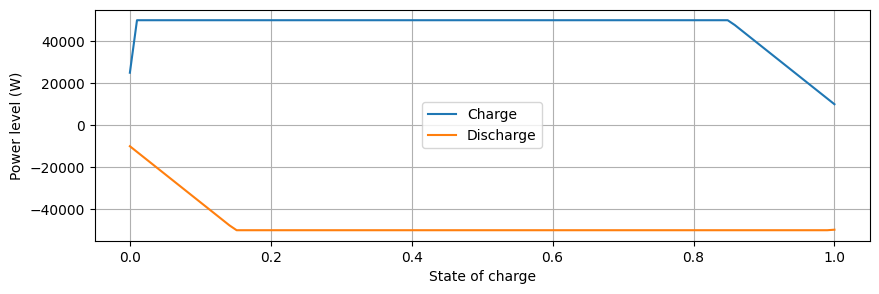

In [19]:
NEC = 100000
SOC = np.array([0,0.01, 0.85, 1.])

# Charging curve 
CPL = np.array([0.25, 0.5, 0.5, 0.1]) * NEC
SOC_to_CPL_function = interp1d(SOC, CPL)

# Discharging curve 
SOC = np.array([0.  , 0.15, 0.99, 2.  ])
DPL = np.array([0.1, 0.5, 0.5, 0.25]) * NEC
SOC_to_DPL_function = interp1d(SOC, DPL)


plt.figure(figsize=(10,3))
plt.plot(np.linspace(0,1,100), SOC_to_CPL_function(np.linspace(0,1,100)), label = "Charge")
plt.plot(np.linspace(0,1,100), -SOC_to_DPL_function(np.linspace(0,1,100)), label = "Discharge")
plt.grid(True)
plt.xlabel("State of charge")
plt.ylabel("Power level (W)")
plt.legend()

bat = Battery(SOC_to_CPL_function, SOC_to_DPL_function, NEC = NEC)





# get max capacity change in one hour of charge/ discharge

In [20]:
def get_max_capacity_change(bat, S=np.linspace(0,1,101)) :

    capacity_change_charge = []
    capacity_change_discharge = []
    time_charge_discharge = 3600

    for initial_SOC in S :
        bat.EC = initial_SOC * bat.NEC 
        new_SOC, _ = bat.charge(time_charge_discharge) 
        capacity_change_charge.append((new_SOC - initial_SOC) * bat.NEC)

        bat.EC = initial_SOC * bat.NEC 
        new_SOC, _ = bat.discharge(time_charge_discharge) 
        capacity_change_discharge.append((new_SOC - initial_SOC) * bat.NEC)
        
    return capacity_change_charge, capacity_change_discharge



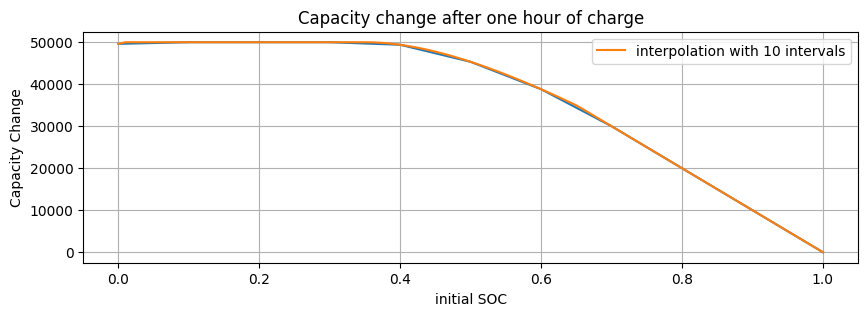

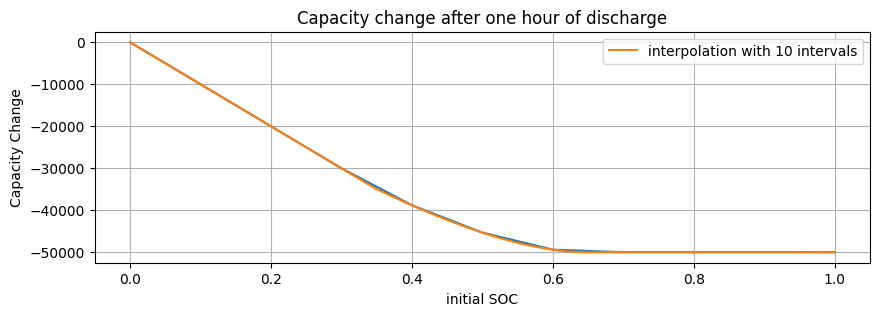

In [48]:
Nint = 10
S = np.linspace(0,1,Nint+1)
G_c, G_d = get_max_capacity_change(bat,S)


Nint2 = 100
S2 = np.linspace(0,1,Nint2+1)
G_c2, G_d2 = get_max_capacity_change(bat,S2)

plt.figure(figsize=(10,3))
plt.grid(True)
plt.plot(S,G_c)
plt.plot(S2,G_c2,label="interpolation with {} intervals".format(Nint))
plt.ylabel("Capacity Change")
plt.xlabel("initial SOC")
plt.title("Capacity change after one hour of charge")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.grid(True)
plt.plot(S,G_d)
plt.plot(S2,G_d2,label="interpolation with {} intervals".format(Nint))
plt.ylabel("Capacity Change")
plt.xlabel("initial SOC")
plt.title("Capacity change after one hour of discharge")
plt.legend()
plt.show()




# Schedule optimization functions :

In [59]:
df_optim

,Country,ISO3 Code,timestamp,Datetime (Local),price_euros_wh,schedule,capacity,SOC
397008,Germany,DEU,2022-01-15 00:00:00,2022-01-15 01:00:00,0.000205,1.455192e-11,0.000000e+00,0.000000e+00
397009,Germany,DEU,2022-01-15 01:00:00,2022-01-15 02:00:00,0.000195,0.000000e+00,1.455192e-11,1.455192e-14
397010,Germany,DEU,2022-01-15 02:00:00,2022-01-15 03:00:00,0.000183,4.960889e+04,1.455192e-11,1.455192e-14
397011,Germany,DEU,2022-01-15 03:00:00,2022-01-15 04:00:00,0.000188,4.540068e+04,4.960889e+04,4.960889e+01
397012,Germany,DEU,2022-01-15 04:00:00,2022-01-15 05:00:00,0.000191,-2.000957e+04,9.500957e+04,9.500957e+01
...,...,...,...,...,...,...,...,...
397123,Germany,DEU,2022-01-19 19:00:00,2022-01-19 20:00:00,0.000125,0.000000e+00,1.136868e-10,1.136868e-13
397124,Germany,DEU,2022-01-19 20:00:00,2022-01-19 21:00:00,0.000121,0.000000e+00,1.136868e-10,1.136868e-13
397125,Germany,DEU,2022-01-19 21:00:00,2022-01-19 22:00:00,0.000118,0.000000e+00,1.136868e-10,1.136868e-13
397126,Germany,DEU,2022-01-19 22:00:00,2022-01-19 23:00:00,0.000097,0.000000e+00,1.136868e-10,1.136868e-13


In [72]:
def optimize_day_by_day(bat,df) :
    """
    Returns a copy of the initial price data frame, with three additional columns :
    - schedule: Change in EC during the hour
    - capacity: Capacity at the end of the hour
    - SOC: SOC at the end of the hour 

    The schedule is optimized **for each day of the dataframe, considered separately.** 
    """


    modules.load() # load all AMPL modules
    ampl = AMPL() # instantiate AMPL object
    ampl.read("ampl.mod")
    ampl.get_parameter("NEC").set_values([bat.NEC])

    Nint = 5
    ampl.get_parameter("Nint").set_values([Nint])

    S = np.linspace(0,1,Nint+1)

    G_c, G_d = get_max_capacity_change(bat,S)

    ampl.get_parameter("G_c").set_values(np.array(G_c))
    ampl.get_parameter("G_d").set_values(np.array(G_d))


    
    n_hours = len(df)
    if  n_hours % 24 != 0 :
        raise Exception("The dataframe should contain only full days (24 hours)")
    
    schedule = np.zeros(n_hours)
    
    ## first day starts with empty battery :
    initial_capacity = 0
    
    ## optimization done for each day :
    for day in range(0,n_hours//24) :

        
        price = df.price_euros_wh.iloc[day*24:(day+1)*24].to_numpy()
        ampl.get_parameter("p").set_values(price)
        ampl.get_parameter("EC_init").set_values([initial_capacity])

        

        # Specify the solver to use (e.g., HiGHS)
        ampl.option["solver"] = "gurobi"
        # Solve
        ampl.solve()

        schedule[day*24:(day+1)*24]  = ampl.get_variable('x').get_values().to_pandas()["x.val"]
        
        initial_capacity = round(initial_capacity + sum(schedule[day*24:(day+1)*24]))

    capacity = np.hstack((np.array([0]),np.cumsum(schedule)[:-1]))
    df_optim = df.copy()
    df_optim["schedule"] = schedule
    df_optim["capacity"] = np.hstack((np.array([0]),np.cumsum(schedule)[:-1]))
    df_optim["SOC"] = 100*df_optim["capacity"]/NEC

    return df_optim

        
        


# Plot functions :

In [24]:
def display_profit(df_optim) :
    """
    Displays daily profits 
    """

    days =pd.to_datetime(df_optim["timestamp"].apply(lambda x: datetime.datetime(x.year, x.month, x.day)),utc=True).unique()
    
    daily_profit = []


    for i in range(len(days)) :
        daily_profit.append(-df_optim.price_euros_wh.iloc[i*24:(i+1)*24] @ df_optim.schedule.iloc[i*24:(i+1)*24])

    fig = make_subplots(specs=[[{"secondary_y": True}]])


    fig.add_trace(go.Scatter(x=df_optim.timestamp, y=df_optim.price_euros_wh*10**6,name='Price (EUR/MWh)',line={"shape":"hv"},showlegend=True),
    secondary_y=False)

    fig.add_trace(go.Bar(x=days,y=daily_profit,name="Daily profit (EUR)",offset=2,showlegend=True,opacity=0.5),
    secondary_y=True)

    fig.update_layout(
    title_text="Daily profit<br>Total: {} EUR<br>Mean: {} EUR".format(int(sum(daily_profit)), int(np.mean(daily_profit)))
    )

    fig.update_xaxes(title_text="Hour")

    fig.update_yaxes(title_text="Price (EUR/MWh)", secondary_y=False)
    fig.update_yaxes(title_text="Daily profit (EUR)", secondary_y=True)

    fig.update_layout(bargap=0.)
    fig.write_html("out/profit.html")
    fig.show()
    


    
    



def display_schedule(df_optim,start,end) :
    """
    Displays charge schedule between start datetime and end datetime 
    """
		
    mask = (df_optim.timestamp<end) & (df_optim.timestamp>=start)
    df_to_show = df_optim[mask]


    fig = make_subplots(specs=[[{"secondary_y": True}]])


    fig.add_trace(go.Scatter(x=df_to_show.timestamp, y=df_to_show.price_euros_wh*10**6,name='Price (EUR/MWh)',line={"shape":"hv"},showlegend=True),
        secondary_y=False)

    fig.add_trace(
        go.Scatter(x=df_to_show.timestamp,y=df_to_show.SOC,name="SOC (%)",showlegend=True),secondary_y=True)



    color = None 
    count = 0

    shapes = []


    for h in df_to_show.index[np.sign(df_to_show.schedule).diff() != 0] : 
        
       
        if (df_to_show.schedule[h] == 0 and not color) or (df_to_show.schedule[h] > 0  and color == "green") or (df_to_show.schedule[h] < 0  and color == "red") :
            continue

        elif df_to_show.schedule[h] == 0 and color :
            shapes.append(dict(type="rect",x0=df_to_show.timestamp[start], y0=1, x1=df_to_show.timestamp[h], y1=100,  yref="y2",fillcolor=color, opacity=0.25, line_width=0))
            color = None

        elif df_to_show.schedule[h] > 0 and color == "red" : 
            shapes.append(dict(type="rect",x0=df_to_show.timestamp[start], y0=1, x1=df_to_show.timestamp[h], y1=100, yref="y2",fillcolor=color, opacity=0.25, line_width=0))
            start = h 
            color = "green"

        elif df_to_show.schedule[h] > 0 and not color :
            start = h
            color = "green"
            
        elif df_to_show.schedule[h] < 0 and color == "green" : 
            shapes.append(dict(type="rect",x0=df_to_show.timestamp[start], y0=1, x1=df_to_show.timestamp[h], y1=100, yref="y2", fillcolor=color, opacity=0.25, line_width=0))
            start = h 
            color = "red"
            
        elif df_to_show.schedule[h] < 0 and not color :
            start = h
            color = "red"






    # Add range slider
    fig.update_layout(
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(step="all"),
                    dict(count=1,
                        label="1m",
                        step="month",
                        stepmode="backward"),
                    dict(count=2*7,
                        label="2w",
                        step="day",
                        stepmode="backward"),
                    dict(count=1*7,
                        label="1w",
                        step="day",
                        stepmode="backward"),
                    dict(count=2,
                        label="2d",
                        step="day",
                        stepmode="backward"),
                    dict(count=1,
                        label="1d",
                        step="day",
                        stepmode="backward"),
                    
                ])
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.update_layout(
        shapes=shapes)


    fig.update_layout(
    title_text="Charge schedule.    Please use the buttons below to set the data range.<br>"
    )

    fig.update_xaxes(title_text="Date")

    fig.update_yaxes(title_text="Price (EUR/MWh)", secondary_y=False)
    fig.update_yaxes(title_text="SOC (%)", secondary_y=True)
        
    fig.show()  
    fig.write_html("out/schedule.html")





    

# Price dataset :

In [25]:
df = pd.read_csv("data/european_wholesale_electricity_price_data_hourly.csv")
df.rename(columns={"Datetime (UTC)":"timestamp","Price (EUR/MWhe)":"price_euros_wh"},inplace=True, errors='raise')
df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%dT%H:%M:%S.%f%Z")

df.price_euros_wh /= 10 ** 6

start = "2022-01-15 00:00:00"
end = "2022-01-20 00:00:00"
country = "Germany"

df = df[df["Country"] == country]
mask = (df.timestamp<end) & (df.timestamp>=start)
df = df[mask]



# Optimize and show schedule :

In [26]:
# df_optim = optimize(df)
df_optim = optimize_day_by_day(bat,df)

   index0    |     G_c     
     0       | 49608.891225284948
     1       | 49999.987123206243
     2       | 50000.000000003944
     3       | 50000.00000000406
     4       | 50000.000000004198
     5       | 50000.000000004329
     6       | 50000.00000000446
     7       | 50000.000000004598
     8       | 50000.000000004729
     9       | 50000.000000004853
     10      | 50000.000000004984
     11      | 50000.000000005108
     12      | 50000.000000005253
     13      | 50000.000000005377
     14      | 50000.000000005508
     15      | 50000.000000005639
     16      | 50000.000000005763
     17      | 50000.000000005806
     18      | 50000.000000005821
     19      | 50000.000000005821
     20      | 50000.000000005821
     21      | 50000.000000005821
     22      | 50000.000000005821
     23      | 50000.000000005821
     24      | 50000.000000005806
     25      | 50000.000000005806
     26      | 50000.000000005821
     27      | 50000.000000005821
     28      | 50000.0

# Show profits :

In [27]:
start_show = start
end_show = end
display_schedule(df_optim,start_show,end_show)

In [28]:
display_profit(df_optim)